# EvilFlowers Metadata Postprocessing

This notebook demonstrates how to read, explore, and clean up the metadata extracted by the EvilFlowers importer. It provides examples of common operations and data transformations that might be useful after the initial extraction process.

## Table of Contents
1. [Loading the Data](#loading-the-data)
2. [Basic Data Exploration](#basic-data-exploration)
3. [Data Cleanup](#data-cleanup)
   - [Fixing Author Names](#fixing-author-names)
   - [Standardizing Titles](#standardizing-titles)
   - [Correcting ISBN/DOI Values](#correcting-isbndoi-values)
   - [Handling Missing Values](#handling-missing-values)
4. [Data Visualization](#data-visualization)
5. [Exporting Cleaned Data](#exporting-cleaned-data)


## Loading the Data

First, let's import the necessary libraries and load the metadata from the progress.json file.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
from pathlib import Path
import ast

# Set up visualization style
plt.style.use('ggplot')
sns.set(style="whitegrid")

# Load the data
progress_file = Path('../output/progress.json')
if progress_file.exists():
    df = pd.read_json(progress_file, orient="records")
    print(f"Loaded {len(df)} records from {progress_file}")
else:
    print(f"File not found: {progress_file}")
    df = pd.DataFrame()


## Basic Data Exploration

Let's explore the data to understand its structure and content.


In [ ]:
# Display basic information about the DataFrame
print("DataFrame Info:")
df.info()


In [ ]:
# Display the first few rows
print("\nSample Data:")
df.head()


In [ ]:
# Check for missing values
print("\nMissing Values Count:")
df.isna().sum()


In [ ]:
# Check data types
print("\nData Types:")
df.dtypes


In [ ]:
# Examine the unique values and their counts for categorical columns
print("\nPublisher Counts:")
df['publisher'].value_counts().head(10)


In [ ]:
# Check the distribution of publication years
print("\nPublication Year Distribution:")
df['year'].value_counts().sort_index().head(10)


### Examining the Authors Field

The 'authors' field can be particularly tricky as it might be stored in different formats. Let's examine it more closely.


In [ ]:
# Check the format of the authors field
print("Authors field examples:")
for i, author in enumerate(df['authors'].head(5)):
    print(f"{i+1}. {author} (type: {type(author).__name__})")


## Data Cleanup

Now that we understand the data, let's clean it up to make it more consistent and usable.


### Fixing Author Names

First, let's ensure that the 'authors' field is consistently a list of strings.


In [10]:
def parse_authors(authors):
    """Convert authors to a list of strings, handling various input formats."""
    # Handle scalar NA values
    if isinstance(authors, (float, int, str, type(None))) and (pd.isna(authors) or authors is None):
        return []

    if isinstance(authors, list):
        return authors

    if isinstance(authors, str):
        # Try to parse as a Python list literal
        try:
            parsed = ast.literal_eval(authors)
            if isinstance(parsed, list):
                return parsed
        except (SyntaxError, ValueError):
            pass

        # If it's a string but not a list literal, split by common separators
        if '|' in authors:
            return [a.strip() for a in authors.split('|') if a.strip()]
        elif ';' in authors:
            return [a.strip() for a in authors.split(';') if a.strip()]
        elif ',' in authors:
            return [a.strip() for a in authors.split(',') if a.strip()]
        else:
            return [authors]

    return [str(authors)]

# Apply the function to standardize the authors field
df['authors_cleaned'] = df['authors'].apply(parse_authors)

# Display the results
print("Original vs. Cleaned Authors:")
for i, (orig, cleaned) in enumerate(zip(df['authors'].head(5), df['authors_cleaned'].head(5))):
    print(f"{i+1}. Original: {orig} (type: {type(orig).__name__})")
    print(f"   Cleaned: {cleaned} (type: {type(cleaned).__name__})")


Original vs. Cleaned Authors:
1. Original: ['Pavol Hudec'] (type: str)
   Cleaned: ['Pavol Hudec'] (type: list)
2. Original: ['Ľuboš Magdolen'] (type: str)
   Cleaned: ['Ľuboš Magdolen'] (type: list)
3. Original: ['Dr. h.c. mult. prof. Ing. František TREBUŇA, CSc.'
 'Ing. Peter SIVÁK, PhD.'] (type: str)
   Cleaned: ['Dr. h.c. mult. prof. Ing. František TREBUŇA, CSc.Ing. Peter SIVÁK, PhD.'] (type: list)
4. Original: ['Prof. Ing. Ján Syč-Milý, CSc.' 'kolektiv'] (type: str)
   Cleaned: ['Prof. Ing. Ján Syč-Milý, CSc.kolektiv'] (type: list)
5. Original: ['K. Ražnjevič'] (type: str)
   Cleaned: ['K. Ražnjevič'] (type: list)


### Standardizing Titles

Let's clean up the titles to ensure consistent capitalization and formatting.


In [11]:
def clean_title(title):
    """Clean and standardize book titles."""
    if pd.isna(title) or title is None:
        return None

    # Convert to string if not already
    title = str(title).strip()

    # Remove extra whitespace
    title = re.sub(r'\s+', ' ', title)

    # Apply title case (capitalize first letter of each word)
    # But preserve common acronyms and special cases
    words = title.split()
    small_words = {'a', 'an', 'and', 'as', 'at', 'but', 'by', 'for', 'if', 'in', 'of', 'on', 'or', 'the', 'to', 'with'}

    for i, word in enumerate(words):
        # Always capitalize first and last word
        if i == 0 or i == len(words) - 1:
            words[i] = word.capitalize()
        # Check if it's an acronym (all uppercase)
        elif word.upper() == word and len(word) > 1:
            words[i] = word  # Keep acronyms as is
        # Check if it's a small word
        elif word.lower() in small_words:
            words[i] = word.lower()
        # Otherwise capitalize
        else:
            words[i] = word.capitalize()

    return ' '.join(words)

# Apply the function to standardize titles
df['title_cleaned'] = df['title'].apply(clean_title)

# Display the results
print("Original vs. Cleaned Titles:")
for i, (orig, cleaned) in enumerate(zip(df['title'].head(5), df['title_cleaned'].head(5))):
    print(f"{i+1}. Original: {orig}")
    print(f"   Cleaned: {cleaned}")


Original vs. Cleaned Titles:
1. Original: Projektovanie vozidiel
   Cleaned: Projektovanie Vozidiel
2. Original: Modelovanie a simulácie v dopravnej technike
   Cleaned: Modelovanie a Simulácie V Dopravnej Technike
3. Original: Tenzometria
   Cleaned: Tenzometria
4. Original: PRUŽNOSŤ A PEVNOSŤ - Riešené príklady
   Cleaned: Pružnosť a PEVNOSŤ - Riešené Príklady
5. Original: Termodynamické tabulky
   Cleaned: Termodynamické Tabulky


### Correcting ISBN/DOI Values

Let's fix the ISBN and DOI fields to ensure they are in the correct format.


In [12]:
def clean_isbn(isbn):
    """Clean and standardize ISBN values."""
    if pd.isna(isbn) or isbn is None:
        return None

    # Convert to string
    isbn_str = str(isbn).strip()

    # Remove non-alphanumeric characters except '-'
    isbn_str = re.sub(r'[^\w-]', '', isbn_str)

    # Check if it's a valid ISBN (simple check for length)
    if len(isbn_str) in [10, 13] and isbn_str.replace('-', '').isdigit():
        return isbn_str
    elif isbn_str.isdigit() and int(isbn_str) > 1900 and int(isbn_str) < 2100:
        # This looks like a year, not an ISBN
        return None
    else:
        # Use the LLM-extracted ISBN if available
        return None

def clean_doi(doi):
    """Clean and standardize DOI values."""
    if pd.isna(doi) or doi is None:
        return None

    # Convert to string
    doi_str = str(doi).strip()

    # Check if it matches the DOI pattern (10.xxxx/yyyy)
    if re.match(r'^10\.\d{4,9}/[-._;()/:A-Za-z0-9]+$', doi_str):
        return doi_str.lower()  # DOIs are case-insensitive
    else:
        return None

# Apply the functions to clean ISBN and DOI fields
df['isbn_cleaned'] = df.apply(lambda row: clean_isbn(row['isbn']) or row['llm_isbn'], axis=1)
df['doi_cleaned'] = df.apply(lambda row: clean_doi(row['doi']) or row['llm_doi'], axis=1)

# Display the results
print("Original vs. Cleaned ISBN/DOI:")
for i in range(min(5, len(df))):
    print(f"{i+1}. ISBN: {df['isbn'].iloc[i]} -> {df['isbn_cleaned'].iloc[i]}")
    print(f"   DOI: {df['doi'].iloc[i]} -> {df['doi_cleaned'].iloc[i]}")


Original vs. Cleaned ISBN/DOI:
1. ISBN: 2003 -> 80-227-1853-X
   DOI: None -> None
2. ISBN: 2011 -> 978-80-227-3624-4
   DOI: None -> None
3. ISBN: 2012 -> 978-80-553-1378-8
   DOI: None -> None
4. ISBN: 2343 -> 284J023936
   DOI: None -> None
5. ISBN: 1975 -> None
   DOI: None -> None


### Handling Missing Values

Let's address missing values in the dataset.


In [13]:
# Check missing values after cleaning
print("Missing values after cleaning:")
missing_counts = pd.DataFrame({
    'Original': df[['title', 'authors', 'publisher', 'year', 'isbn', 'doi']].isna().sum(),
    'Cleaned': df[['title_cleaned', 'authors_cleaned', 'publisher', 'year', 'isbn_cleaned', 'doi_cleaned']].isna().sum()
})
missing_counts


Missing values after cleaning:


,Original,Cleaned
authors,0.0,NaN
authors_cleaned,NaN,0.0
doi,122.0,NaN
doi_cleaned,NaN,122.0
isbn,0.0,NaN
isbn_cleaned,NaN,56.0
publisher,9.0,9.0
title,1.0,NaN
title_cleaned,NaN,1.0
year,24.0,24.0


In [14]:
# Create a clean version of the DataFrame with all our cleaned fields
df_clean = df.copy()
df_clean['title'] = df['title_cleaned']
df_clean['authors'] = df['authors_cleaned']
df_clean['isbn'] = df['isbn_cleaned']
df_clean['doi'] = df['doi_cleaned']

# Fix the year field if it's numeric
def clean_year(year):
    if pd.isna(year) or year is None:
        return None

    year_str = str(year).strip()
    if year_str.isdigit() and int(year_str) > 1800 and int(year_str) < 2100:
        return year_str
    return None

df_clean['year'] = df['year'].apply(clean_year)

# Drop the temporary columns we created during cleaning
df_clean = df_clean.drop(columns=['title_cleaned', 'authors_cleaned', 'isbn_cleaned', 'doi_cleaned'], errors='ignore')

# Display the cleaned DataFrame
print("Cleaned DataFrame:")
df_clean.head()


Cleaned DataFrame:


,dirname,title,authors,publisher,year,isbn,doi,llm_isbn,llm_doi,summary,cover_image,pdf_path
0,/Volumes/SJF/CVI_OPACID_SJF_802271853_X,Projektovanie Vozidiel,[Pavol Hudec],Slovenská technická univerzita v Bratislave,2003,80-227-1853-X,None,80-227-1853-X,None,"The text discusses a 2003 book titled ""MOTOROV...",/Volumes/SJF/CVI_OPACID_SJF_802271853_X/Cover/...,None
1,/Volumes/SJF/CVI_OPACID_SJF_9788022736244,Modelovanie a Simulácie V Dopravnej Technike,[Ľuboš Magdolen],SLOVENSKÁ TECHNICKÁ UNIVERZITA V BRATISLAVE,2011,978-80-227-3624-4,None,978-80-227-3624-4,None,This text discusses the importance and methods...,/Volumes/SJF/CVI_OPACID_SJF_9788022736244/Cove...,None
2,/Volumes/SJF/CVI_OPACID_SJF_9788055313788,Tenzometria,"[Dr. h.c. mult. prof. Ing. František TREBUŇA, ...",TECHNICKÁ UNIVERZITA V KOŠICIACH,2012,978-80-553-1378-8,None,978-80-553-1378-8,None,The text discusses various strain measurement ...,/Volumes/SJF/CVI_OPACID_SJF_9788055313788/Cove...,None
3,/Volumes/SJF/CVI_OPACID_SJF_PRUZNOST_1988,Pružnosť a PEVNOSŤ - Riešené Príklady,"[Prof. Ing. Ján Syč-Milý, CSc.kolektiv]",VYDAVATEĽSTVO TECHNICKEJ A EKONOMICKEJ LITERATÚRY,1988,284J023936,None,284J023936,None,The text discusses various engineering problem...,/Volumes/SJF/CVI_OPACID_SJF_PRUZNOST_1988/Cove...,None
4,/Volumes/SJF/CVI_OPACID_SJF_TERMODINAMICKE,Termodynamické Tabulky,[K. Ražnjevič],VYDAVATEĽSTVO TECHNICKEJ A EKONOMICKEJ LITERAT...,None,None,None,None,None,The text contains two tables and a discussion ...,/Volumes/SJF/CVI_OPACID_SJF_TERMODINAMICKE/Cov...,None


## Data Visualization

Let's create some visualizations to better understand the dataset.


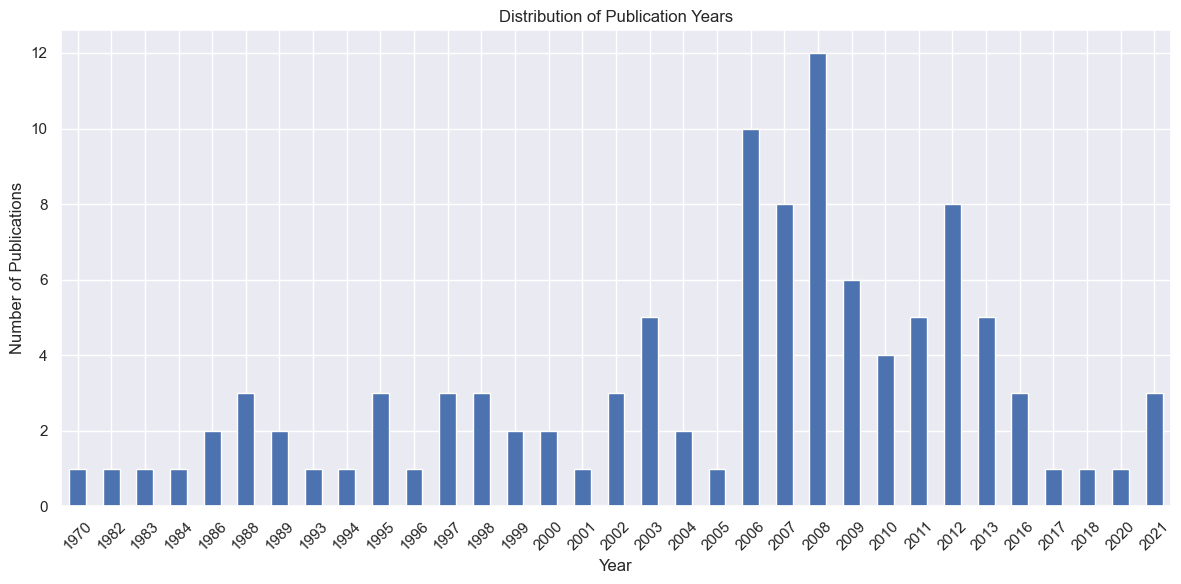

In [15]:
# Publication years distribution
plt.figure(figsize=(12, 6))
year_counts = df_clean['year'].dropna().value_counts().sort_index()
year_counts.plot(kind='bar')
plt.title('Distribution of Publication Years')
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


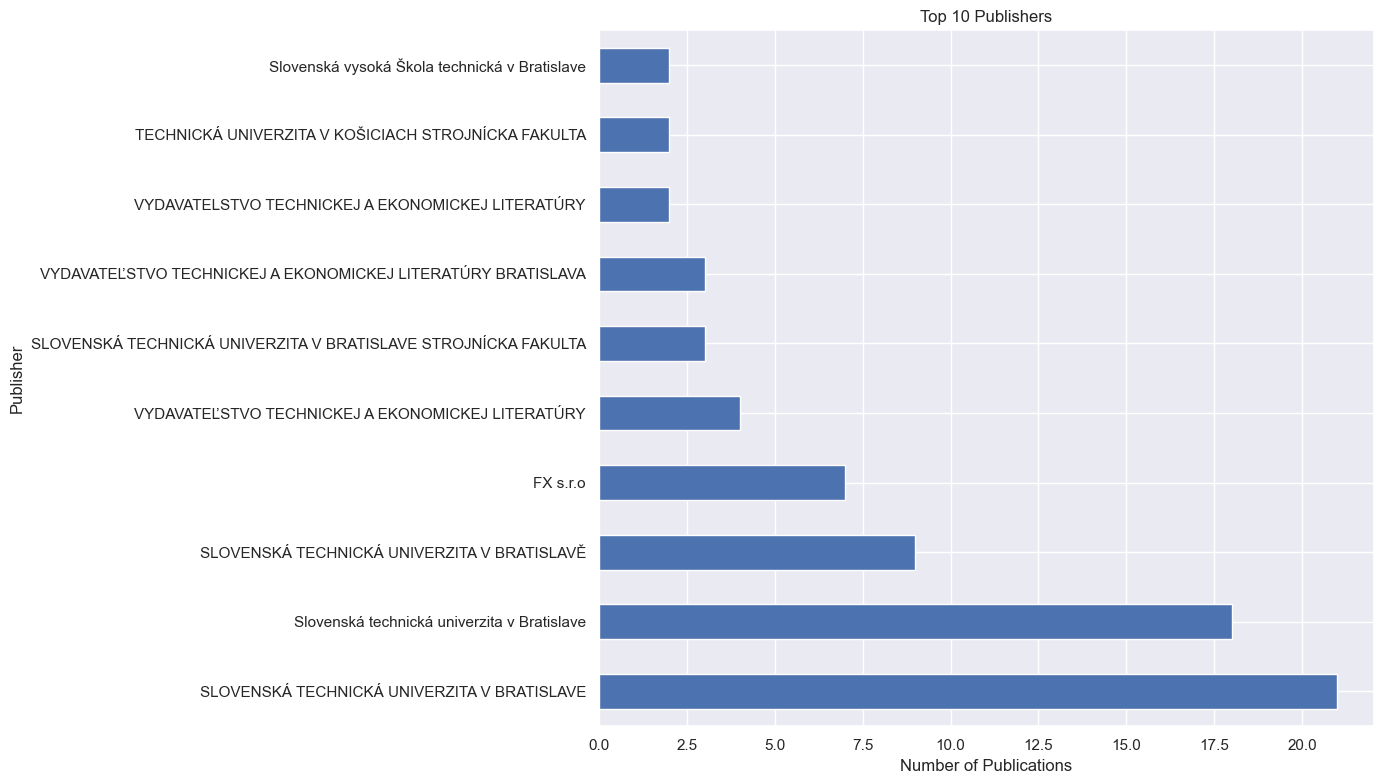

In [16]:
# Top publishers
plt.figure(figsize=(14, 8))
publisher_counts = df_clean['publisher'].value_counts().head(10)
publisher_counts.plot(kind='barh')
plt.title('Top 10 Publishers')
plt.xlabel('Number of Publications')
plt.ylabel('Publisher')
plt.tight_layout()
plt.show()


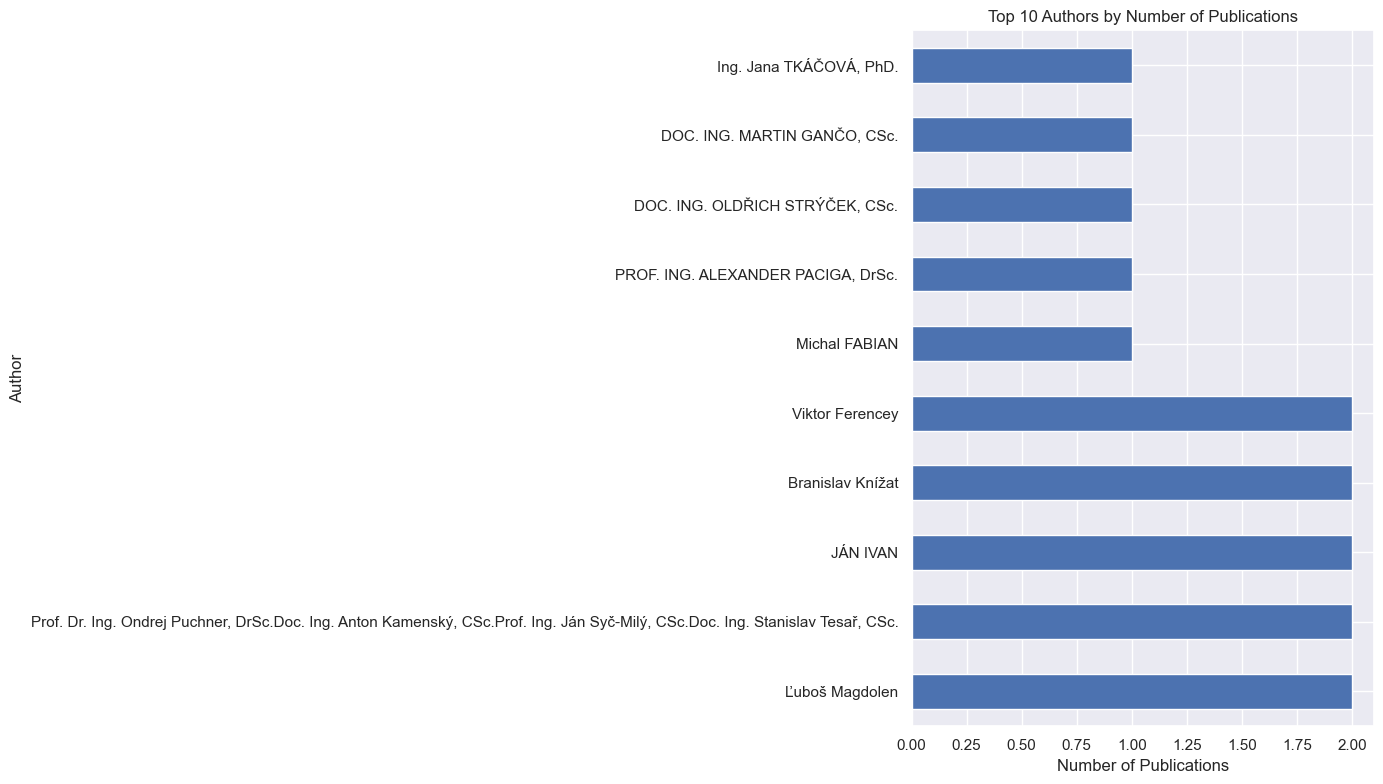

In [17]:
# Analyze author contributions
# Flatten the list of authors
all_authors = [author for authors_list in df_clean['authors'] for author in authors_list if authors_list]
author_counts = pd.Series(all_authors).value_counts().head(10)

plt.figure(figsize=(14, 8))
author_counts.plot(kind='barh')
plt.title('Top 10 Authors by Number of Publications')
plt.xlabel('Number of Publications')
plt.ylabel('Author')
plt.tight_layout()
plt.show()


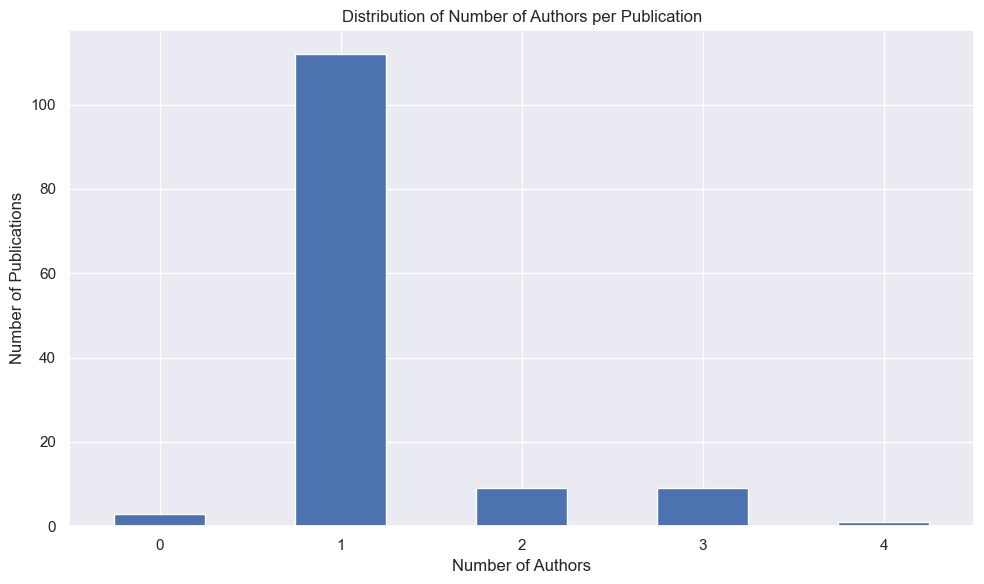

In [18]:
# Analyze the number of authors per publication
df_clean['author_count'] = df_clean['authors'].apply(lambda x: len(x) if isinstance(x, list) else 0)
author_count_dist = df_clean['author_count'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
author_count_dist.plot(kind='bar')
plt.title('Distribution of Number of Authors per Publication')
plt.xlabel('Number of Authors')
plt.ylabel('Number of Publications')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## Exporting Cleaned Data

Finally, let's export the cleaned data back to a JSON file.


In [ ]:
# Function to convert DataFrame to JSON-serializable format
def df_to_json_records(df):
    """Convert DataFrame to a list of records suitable for JSON serialization."""
    records = df.to_dict(orient='records')
    return records

# Export the cleaned data
output_file = Path('../output/progress_cleaned.json')
with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(df_to_json_records(df_clean), f, ensure_ascii=False, indent=4)

print(f"Cleaned data exported to {output_file}")


## Enriching Data with External Sources

Let's use external libraries to fetch additional metadata for our publications and enhance our dataset.


### Fetching Metadata with isbnlib

We can use the isbnlib library to fetch additional metadata for books that have valid ISBNs.


In [19]:
import isbnlib

In [20]:
# Function to fetch metadata using ISBN
def fetch_isbn_metadata(isbn):
    """
    Fetch metadata for a book using its ISBN.
    Returns None if the ISBN is invalid or no metadata is found.
    """
    if not isbn or not isinstance(isbn, str):
        return None

    # Clean the ISBN (remove hyphens, spaces, etc.)
    clean_isbn = isbnlib.canonical(isbn)
    if not clean_isbn:
        return None

    try:
        # Try to fetch metadata from multiple sources
        for service in ['goob', 'openl', 'wiki']:
            try:
                metadata = isbnlib.meta(clean_isbn, service=service)
                if metadata:
                    return metadata
            except Exception as e:
                print(f"Error fetching metadata from {service} for ISBN {isbn}: {e}")
                continue
    except Exception as e:
        print(f"Error fetching metadata for ISBN {isbn}: {e}")

    return None

# Test the function with a sample ISBN
sample_isbn = df_clean['isbn'].dropna().iloc[0] if not df_clean['isbn'].dropna().empty else None
if sample_isbn:
    print(f"Fetching metadata for sample ISBN: {sample_isbn}")
    sample_metadata = fetch_isbn_metadata(sample_isbn)
    print(f"Sample metadata: {sample_metadata}")
else:
    print("No valid ISBN found in the dataset for testing")


Fetching metadata for sample ISBN: 80-227-1853-X
Sample metadata: {'ISBN-13': '9788022718530', 'Title': 'Motorové vozidlá - Projektovanie vozidiel. III', 'Authors': ['Pavol Hudec'], 'Publisher': '', 'Year': '2003', 'Language': 'sk'}


In [21]:
# Apply the function to all rows with valid ISBNs and update the DataFrame
print("Fetching metadata for all books with valid ISBNs...")
enriched_records = []

for i, row in df_clean.iterrows():
    if i % 10 == 0:
        print(f"Processing record {i+1}/{len(df_clean)}...")

    isbn = row['isbn']
    if isbn and isinstance(isbn, str):
        metadata = fetch_isbn_metadata(isbn)
        if metadata:
            # Update the record with the fetched metadata
            # isbnlib metadata keys: 'ISBN-13', 'Title', 'Authors', 'Publisher', 'Year', 'Language'
            row_dict = row.to_dict()

            # Override extracted data with fetched data
            row_dict['title'] = metadata.get('Title', row_dict['title'])
            row_dict['authors'] = metadata.get('Authors', row_dict['authors'])
            row_dict['publisher'] = metadata.get('Publisher', row_dict['publisher'])
            row_dict['year'] = metadata.get('Year', row_dict['year'])

            # Add new fields from the metadata
            row_dict['language'] = metadata.get('Language')

            enriched_records.append(row_dict)
        else:
            enriched_records.append(row.to_dict())
    else:
        enriched_records.append(row.to_dict())

# Create a new DataFrame with the enriched records
df_enriched = pd.DataFrame(enriched_records)
print(f"Enriched {len([r for r in enriched_records if 'language' in r and r['language'] is not None])} records with additional metadata")

# Display a sample of the enriched records
print("\nSample of enriched records:")
df_enriched.head()


Fetching metadata for all books with valid ISBNs...
Processing record 1/134...
Error fetching metadata from wiki for ISBN 978-80-227-3624-4: an HTTP error has ocurred ((404) Not Found)
Error fetching metadata from wiki for ISBN 978-80-553-1378-8: an HTTP error has ocurred ((404) Not Found)
Processing record 11/134...
Processing record 21/134...
Error fetching metadata from wiki for ISBN 978-80-227-3820-0: an HTTP error has ocurred ((404) Not Found)
Error fetching metadata from wiki for ISBN 978-80-89313-07-5: an HTTP error has ocurred ((404) Not Found)
Error fetching metadata from wiki for ISBN 978-80-89313-36-5: an HTTP error has ocurred ((404) Not Found)
Error fetching metadata from wiki for ISBN 978-80-970524-0-9: an HTTP error has ocurred ((404) Not Found)
Error fetching metadata from wiki for ISBN 978-80-972555-0-3: an HTTP error has ocurred ((404) Not Found)
Error fetching metadata from wiki for ISBN 978-80-970 897-2-6: an HTTP error has ocurred ((404) Not Found)
Processing recor

,dirname,title,authors,publisher,year,isbn,doi,llm_isbn,llm_doi,summary,cover_image,pdf_path,author_count,language
0,/Volumes/SJF/CVI_OPACID_SJF_802271853_X,Motorové vozidlá - Projektovanie vozidiel. III,[Pavol Hudec],,2003,80-227-1853-X,None,80-227-1853-X,None,"The text discusses a 2003 book titled ""MOTOROV...",/Volumes/SJF/CVI_OPACID_SJF_802271853_X/Cover/...,None,1,sk
1,/Volumes/SJF/CVI_OPACID_SJF_9788022736244,Modelovanie a Simulácie V Dopravnej Technike,[Ľuboš Magdolen],SLOVENSKÁ TECHNICKÁ UNIVERZITA V BRATISLAVE,2011,978-80-227-3624-4,None,978-80-227-3624-4,None,This text discusses the importance and methods...,/Volumes/SJF/CVI_OPACID_SJF_9788022736244/Cove...,None,1,NaN
2,/Volumes/SJF/CVI_OPACID_SJF_9788055313788,Tenzometria,"[Dr. h.c. mult. prof. Ing. František TREBUŇA, ...",TECHNICKÁ UNIVERZITA V KOŠICIACH,2012,978-80-553-1378-8,None,978-80-553-1378-8,None,The text discusses various strain measurement ...,/Volumes/SJF/CVI_OPACID_SJF_9788055313788/Cove...,None,1,NaN
3,/Volumes/SJF/CVI_OPACID_SJF_PRUZNOST_1988,Pružnosť a PEVNOSŤ - Riešené Príklady,"[Prof. Ing. Ján Syč-Milý, CSc.kolektiv]",VYDAVATEĽSTVO TECHNICKEJ A EKONOMICKEJ LITERATÚRY,1988,284J023936,None,284J023936,None,The text discusses various engineering problem...,/Volumes/SJF/CVI_OPACID_SJF_PRUZNOST_1988/Cove...,None,1,NaN
4,/Volumes/SJF/CVI_OPACID_SJF_TERMODINAMICKE,Termodynamické Tabulky,[K. Ražnjevič],VYDAVATEĽSTVO TECHNICKEJ A EKONOMICKEJ LITERAT...,None,None,None,None,None,The text contains two tables and a discussion ...,/Volumes/SJF/CVI_OPACID_SJF_TERMODINAMICKE/Cov...,None,1,NaN


## Improving Descriptions with a Local LLM

Let's use a local Mistral model to improve the descriptions and make them more human-readable. We'll use the same approach as in the evilflowers_importer module, which follows a well-structured design pattern:

1. Define an `AIModelInterface` that specifies the methods all AI models must implement
2. Create a concrete implementation for the Mistral model that follows this interface
3. Use a factory pattern to create the appropriate model
4. Use the model to improve the descriptions

This approach makes the code more modular, maintainable, and consistent with the rest of the project.


In [24]:
# Import the AI model interface and factory from evilflowers_importer
import sys
import os
import logging

# Add the parent directory to the path so we can import from evilflowers_importer
sys.path.append(os.path.abspath('..'))

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Import the AI model interface and factory
from evilflowers_importer.ai_models import AIModelInterface, AIModelFactory
from abc import ABC, abstractmethod
from langchain.llms import HuggingFacePipeline
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import torch

# Define a new MistralModel class that implements AIModelInterface
class MistralModel(AIModelInterface):
    """Implementation of AIModelInterface for local Mistral model using HuggingFace."""

    def __init__(self, model_name: str = "mistralai/Mistral-7B-Instruct-v0.2", max_new_tokens: int = 512, 
                 temperature: float = 0.7, top_p: float = 0.95, repetition_penalty: float = 1.15):
        """
        Initialize the Mistral model.

        Args:
            model_name (str): The name of the Mistral model to use.
            max_new_tokens (int): Maximum number of tokens to generate.
            temperature (float): Controls randomness in generation. Higher is more random.
            top_p (float): Controls diversity via nucleus sampling. Lower is less diverse.
            repetition_penalty (float): Penalizes repetition. Higher means less repetition.
        """
        self.model_name = model_name
        self.max_new_tokens = max_new_tokens
        self.temperature = temperature
        self.top_p = top_p
        self.repetition_penalty = repetition_penalty
        self.llm = None

        # Check if CUDA is available
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        logger.info(f"Using device: {self.device}")

        try:
            # Load the tokenizer
            logger.info(f"Loading tokenizer for {model_name}...")
            self.tokenizer = AutoTokenizer.from_pretrained(model_name)

            # Load the model
            logger.info(f"Loading model {model_name}...")
            self.model = AutoModelForCausalLM.from_pretrained(
                model_name,
                torch_dtype=torch.float16 if self.device == "cuda" else torch.float32,
                device_map="auto" if self.device == "cuda" else None,
                low_cpu_mem_usage=True if self.device == "cuda" else False
            )

            # Create a text generation pipeline
            self.pipe = pipeline(
                "text-generation",
                model=self.model,
                tokenizer=self.tokenizer,
                max_new_tokens=self.max_new_tokens,
                temperature=self.temperature,
                top_p=self.top_p,
                repetition_penalty=self.repetition_penalty
            )

            # Create a LangChain wrapper around the pipeline
            self.llm = HuggingFacePipeline(pipeline=self.pipe)
            logger.info("Model loaded successfully!")

        except Exception as e:
            logger.error(f"Error loading the model: {e}")
            logger.warning("Model will not be available for text generation.")

    def generate_text(self, prompt: str, temperature: float = None) -> str:
        """
        Generate text based on a prompt.

        Args:
            prompt (str): The prompt to generate text from.
            temperature (float): Controls randomness in generation. Lower is more deterministic.
                                If None, uses the default temperature from initialization.

        Returns:
            str: The generated text.
        """
        if self.llm is None:
            return f"ERROR: Model not loaded"

        try:
            # Use the provided temperature if given, otherwise use the default
            if temperature is not None and temperature != self.temperature:
                # Create a new pipeline with the different temperature
                temp_pipe = pipeline(
                    "text-generation",
                    model=self.model,
                    tokenizer=self.tokenizer,
                    max_new_tokens=self.max_new_tokens,
                    temperature=temperature,
                    top_p=self.top_p,
                    repetition_penalty=self.repetition_penalty
                )
                temp_llm = HuggingFacePipeline(pipeline=temp_pipe)
                response = temp_llm(prompt)
            else:
                # Use the default pipeline
                response = self.llm(prompt)

            return response.strip()
        except Exception as e:
            logger.error(f"Error generating text: {e}")
            return f"ERROR: Failed to generate text: {str(e)}"

    def count_tokens(self, text: str) -> int:
        """
        Count the number of tokens in a text.

        Args:
            text (str): The text to count tokens for.

        Returns:
            int: The number of tokens.
        """
        if self.tokenizer is None:
            # Fallback to a simple approximation if tokenizer is not available
            return len(text.split()) * 1.3

        return len(self.tokenizer.encode(text))

# Register the MistralModel with the AIModelFactory
AIModelFactory.create_model = classmethod(lambda cls, model_type, **kwargs: 
    MistralModel(**kwargs) if model_type.lower() == "mistral" else 
    super(AIModelFactory, cls).create_model(model_type, **kwargs)
)

# Create the AI model
try:
    print("Creating Mistral model...")
    ai_model = AIModelFactory.create_model("mistral")
    print("Mistral model created successfully!")
except Exception as e:
    print(f"Error creating Mistral model: {e}")
    print("Falling back to using a simpler approach...")
    ai_model = None


INFO:__main__:Using device: cpu
INFO:__main__:Loading tokenizer for mistralai/Mistral-7B-Instruct-v0.2...


Creating Mistral model...


ERROR:__main__:Error loading the model: You are trying to access a gated repo.
Make sure to have access to it at https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.2.
401 Client Error. (Request ID: Root=1-685bae8d-3b285d72138eef353eddf1de;513d017d-b807-4628-9616-f9b7334fd13e)

Cannot access gated repo for url https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.2/resolve/main/config.json.
Access to model mistralai/Mistral-7B-Instruct-v0.2 is restricted. You must have access to it and be authenticated to access it. Please log in.


Mistral model created successfully!


In [ ]:
# Function to improve a description using the AI model
def improve_description(summary, title=None, authors=None, model=ai_model):
    """
    Improve a book description using the AI model to make it more human-readable.

    Args:
        summary (str): The original book description to improve.
        title (str, optional): The book title for context.
        authors (list, optional): The book authors for context.
        model (AIModelInterface, optional): The AI model to use. Defaults to ai_model.

    Returns:
        str: The improved description, or the original if improvement failed.
    """
    if not summary:
        return None

    # If the AI model failed to load, return the original summary
    if model is None:
        logger.warning("AI model not available, returning original summary")
        return summary

    # Create a prompt for the AI model
    context = f"Title: {title}\nAuthors: {authors}\n" if title and authors else ""
    prompt = f"""
{context}
Original description: {summary}

Please rewrite this book description to make it more engaging and human-readable, like you would find on an online bookstore or in a library catalog. Avoid phrases like "The provided text covers..." and make it sound more popular and appealing to readers. Keep all the important information about the content but make it more conversational and interesting.

Improved description:
"""

    try:
        # Generate the improved description using the AI model
        response = model.generate_text(prompt, temperature=0.7)

        # Check if the response is an error message
        if response.startswith("ERROR:"):
            logger.error(f"AI model returned an error: {response}")
            return summary

        # Clean up the response
        improved = response.strip()

        # Remove any "Improved description:" prefix if present
        if "Improved description:" in improved:
            improved = improved.split("Improved description:", 1)[1].strip()

        return improved
    except Exception as e:
        logger.error(f"Error improving description: {e}")
        return summary

# Test the function with a sample summary
sample_idx = 0
sample_summary = df_enriched['summary'].iloc[sample_idx]
sample_title = df_enriched['title'].iloc[sample_idx]
sample_authors = df_enriched['authors'].iloc[sample_idx]

print(f"Original summary: {sample_summary[:200]}...")
improved_summary = improve_description(sample_summary, sample_title, sample_authors, model=ai_model)
print(f"\nImproved summary: {improved_summary[:200]}...")


In [ ]:
# Apply the function to all rows and update the DataFrame
print("Improving descriptions for all books...")
df_enriched['improved_summary'] = None

# Create a progress counter
total_records = len(df_enriched)
processed_records = 0

for i, row in df_enriched.iterrows():
    if i % 10 == 0:
        print(f"Processing record {i+1}/{total_records}... ({processed_records} improved)")

    summary = row['summary']
    title = row['title']
    authors = row['authors']

    if summary:
        # Use the AI model to improve the description
        improved = improve_description(summary, title, authors, model=ai_model)
        df_enriched.at[i, 'improved_summary'] = improved

        # Count successfully improved summaries
        if improved != summary:
            processed_records += 1

# Replace the original summaries with the improved ones
df_enriched['original_summary'] = df_enriched['summary']
df_enriched['summary'] = df_enriched['improved_summary'].fillna(df_enriched['summary'])
df_enriched = df_enriched.drop(columns=['improved_summary'], errors='ignore')

# Display a sample of the improved descriptions
print(f"\nSample of improved descriptions (total improved: {processed_records}/{total_records}):")
for i in range(min(3, len(df_enriched))):
    print(f"\nBook {i+1}: {df_enriched['title'].iloc[i]}")
    print(f"Original: {df_enriched['original_summary'].iloc[i][:200]}...")
    print(f"Improved: {df_enriched['summary'].iloc[i][:200]}...")

    # Check if the summary was actually improved
    if df_enriched['original_summary'].iloc[i] != df_enriched['summary'].iloc[i]:
        print("Status: ✅ Improved")
    else:
        print("Status: ⚠️ Unchanged (model unavailable or error occurred)")


## Exporting Enriched Data

Finally, let's export the enriched data back to a JSON file.


In [ ]:
# Export the enriched data
output_file = Path('../output/progress_enriched.json')
with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(df_to_json_records(df_enriched), f, ensure_ascii=False, indent=4)

print(f"Enriched data exported to {output_file}")


## Conclusion

In this notebook, we've demonstrated how to:

1. Load and explore the metadata from the progress.json file
2. Clean and standardize various fields including authors, titles, ISBNs, and DOIs
3. Handle missing values and inconsistencies in the data
4. Visualize the data to gain insights
5. Enrich the data with additional metadata from external sources using isbnlib
6. Improve descriptions using a local Mistral model to make them more human-readable
7. Export the enriched data for further use

This process can be customized and extended based on specific needs and requirements.
